Author: Dana Chermesh Reshef, CUSP 2017
### Problem set#2: 
# Social/community impacts of building energy use and emissions

# Introduction
### _By Prof. C.E. Kontokosta, CUSP 2017_

_Energy use in buildings accounts for approximately 79% of all of New York City’s energy consumption and carbon emissions. In an effort to improve its sustainability and efficiency, the City adopted an ambitious goal of reducing carbon emissions by 80% by the year 2050. The New York City Mayor’s Office of Sustainability (MOS) is responsible for implementing this plan, which calls for major reductions in building energy use (The City of New York, 2016). One significant analytical challenge is to develop a robust method for peer comparison and benchmarking of buildings. This is necessary to understand relative building energy performance, given the specific characteristics of a building, and to design regulations that require buildings to meet a certain energy performance standard. Another concern revolves around environmental justice and the impact of building energy use and emissions on local communities. The question is whether low-income communities disproportionately bear the burden of inefficient buildings and possible negative effects on health._

# Data and Analysis

In [1]:
from __future__ import print_function, division
import sys
import os
import pandas as pd
import numpy as np
import sys
import operator
from scipy import stats
import requests
from IPython.display import HTML
import matplotlib.pylab as pl
import warnings
import geopandas as gpd
from fiona.crs import from_epsg
import statsmodels.formula.api as smf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read in LL84 energy performance data (2016)
 **LL84 data** were retrieved from http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml

In [2]:
!wget http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx

--2017-11-14 02:58:17--  http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx
Resolving www.nyc.gov... 23.66.229.194, 2600:1400:a:18f::1500, 2600:1400:a:1a3::1500
Connecting to www.nyc.gov|23.66.229.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4298814 (4.1M) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: “nyc_benchmarking_disclosure_data_reported_in_2016.xlsx.35”

100%[======================================>] 4,298,814   23.5M/s   in 0.2s    

2017-11-14 02:58:17 (23.5 MB/s) - “nyc_benchmarking_disclosure_data_reported_in_2016.xlsx.35” saved [4298814/4298814]



In [3]:
# Read ll84 data
ll84 = pd.read_excel("http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx")

# Convert to csv
ll84.to_csv(r'..\data\nyc_benchmarking_disclosure_data_reported_in_2016.csv',encoding='utf-8')
ll84 = pd.read_csv(r'..\data\nyc_benchmarking_disclosure_data_reported_in_2016.csv')
ll84.head()

,Unnamed: 0,Record Number,Order,"NYC Borough, Block and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,...,Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft²),Property GFA - Self-reported (ft²),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft²),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method
0,0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,...,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN
1,1,4630135.0,2,1.010618e+09,NaN,NaN,1026728,(7478) - 432 West 52nd Street Condominium,Not Applicable: Standalone Property,Not Applicable: Standalone Property,...,76.4,125.0,58851.0,57401.0,768.5,13.39,2016-04-26 21:52:05,NaN,Not Eligible,NaN
2,2,4626594.0,3,1.014270e+09,NaN,NaN,1043974,(9250) - 250 East 73rd Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,...,145.5,392.9,166432.0,166433.0,11901.5,71.51,2016-04-26 22:56:36,11897.0,Eligible,Manual
3,3,4626608.0,4,1.015180e+09,NaN,NaN,1048117,(9141) - 141 East 89th Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,...,304.6,394.7,114939.0,114939.0,7455.1,64.86,2016-04-26 22:38:03,7455.1,Eligible,ABS
4,4,5048763.0,5,1.003920e+09,NaN,NaN,1079685,605 East 9th ST,Not Applicable: Standalone Property,Not Applicable: Standalone Property,...,0.0,0.0,93420.0,111000.0,NaN,NaN,2016-07-28 17:28:14,NaN,NaN,NaN


In [4]:
del ll84['Unnamed: 0']
cols = ll84.columns.str.replace('\xc2\xb2', '_2')
ll84.columns = cols

In [5]:
ll84.columns

Index([u'Record Number', u'Order', u'NYC Borough, Block and Lot (BBL)',
       u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identification Numbers (BINs)',
       u'Property Name', u'Parent Property Id', u'Parent Property Name',
       u'Street Number', u'Street Name', u'Zip Code', u'Borough',
       u'DOF Benchmarking Submission Status',
       u'Primary Property Type - Self Selected',
       u'List of All Property Use Types at Property',
       u'Largest Property Use Type',
       u'Largest Property Use Type - Gross Floor Area (ft_2)',
       u'2nd Largest Property Use Type',
       u'2nd Largest Property Use - Gross Floor Area (ft_2)',
       u'3rd Largest Property Use Type',
       u'3rd Largest Property Use Type - Gross Floor Area (ft_2)',
       u'Year Built', u'Number of Buildings - Self-reported', u'Occupancy',
       u'Metered Areas (Energy)', u'Metered Areas  (Water)',
       u'ENERGY STAR Score', u'Site EUI (kBtu/ft_2)',
       u'Weather Nor

## Data inspection
### Most encounterd building typologies

In [6]:
proptype = ll84['Primary Property Type - Self Selected']
proptype.value_counts()[:6]

Multifamily Housing           8699
Office                        1233
See Primary BBL                447
Hotel                          236
Non-Refrigerated Warehouse     177
Other                          129
Name: Primary Property Type - Self Selected, dtype: int64

### For part2 of the research, I will focus on Multifamily Housing Energy Performance only. This data will be isolated later in the research.

## Data cleaning

In [7]:
# drop NaNs
ll84 = ll84.dropna(subset=['Site EUI (kBtu/ft_2)'])
print('Examples after droping NaNs:', len(ll84))

Examples after droping NaNs: 11439


In [8]:
# drop zero EUI values
ll84 = ll84[ll84['Site EUI (kBtu/ft_2)']>0]
print('Examples after droping EUI zero values:',len(ll84))

Examples after droping EUI zero values: 11422


<function matplotlib.pyplot.show>

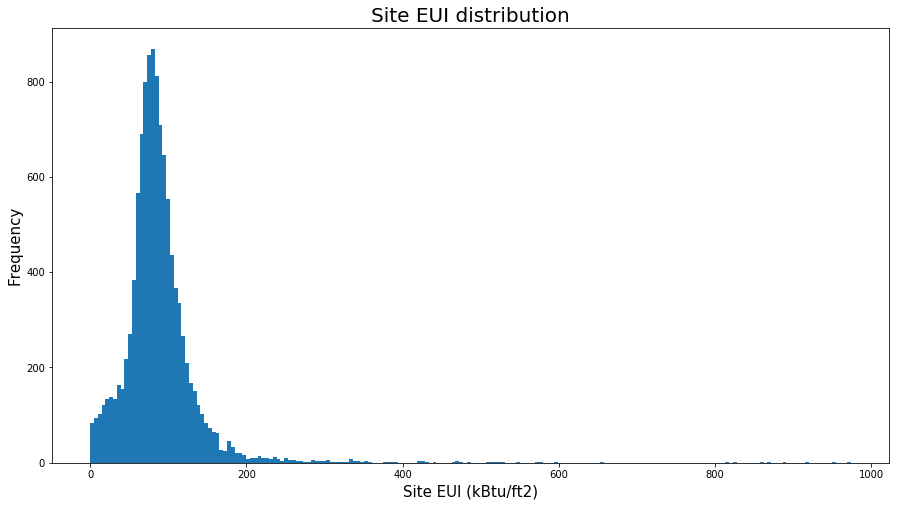

In [9]:
fig = figsize(15,8)
pl.hist(ll84['Site EUI (kBtu/ft_2)'][ll84['Site EUI (kBtu/ft_2)']<1000], bins=200)
pl.title('Site EUI distribution', fontsize=20)
pl.xlabel('Site EUI (kBtu/ft2)', fontsize=15)
pl.ylabel('Frequency', fontsize=15)
pl.show

### Fig.1 Site EUI distribution
The distribution seems to need more cleaning; Thus a limit of two std from the mean, so as observing the log of the distribution, will be implied.


In [10]:
len(ll84)

11422

In [11]:
# Make it a normal distribution -- make it two std (95%) from the mean (405.938456)

def clean(df):
    """Takes the log of EUI for particular building type and filters out examples
    that fall outside the threshold of two std
    return outlier-free dataframe"""
    
    df = df[(df.log_eui<np.mean(df.log_eui)+2*np.std(df.log_eui))&(df.log_eui>np.mean(df.log_eui)-2*np.std(df.log_eui))]
    return df

ll84['eui'] = ll84['Site EUI (kBtu/ft_2)']
ll84['log_eui'] = np.log10(ll84.eui)
ll84 = clean(ll84)
print('example after cleaning EUI:', len(ll84))

example after cleaning EUI: 10995


In [12]:
ll84.head(3)

,Record Number,Order,"NYC Borough, Block and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,...,DOF Property Floor Area (ft_2),Property GFA - Self-reported (ft_2),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft_2),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method,eui,log_eui
0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,...,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN,73.7,1.867467
1,4630135.0,2,1.010618e+09,NaN,NaN,1026728,(7478) - 432 West 52nd Street Condominium,Not Applicable: Standalone Property,Not Applicable: Standalone Property,432.0,...,58851.0,57401.0,768.5,13.39,2016-04-26 21:52:05,NaN,Not Eligible,NaN,51.3,1.710117
2,4626594.0,3,1.014270e+09,NaN,NaN,1043974,(9250) - 250 East 73rd Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1393.0,...,166432.0,166433.0,11901.5,71.51,2016-04-26 22:56:36,11897.0,Eligible,Manual,44.9,1.652246


<function matplotlib.pyplot.show>

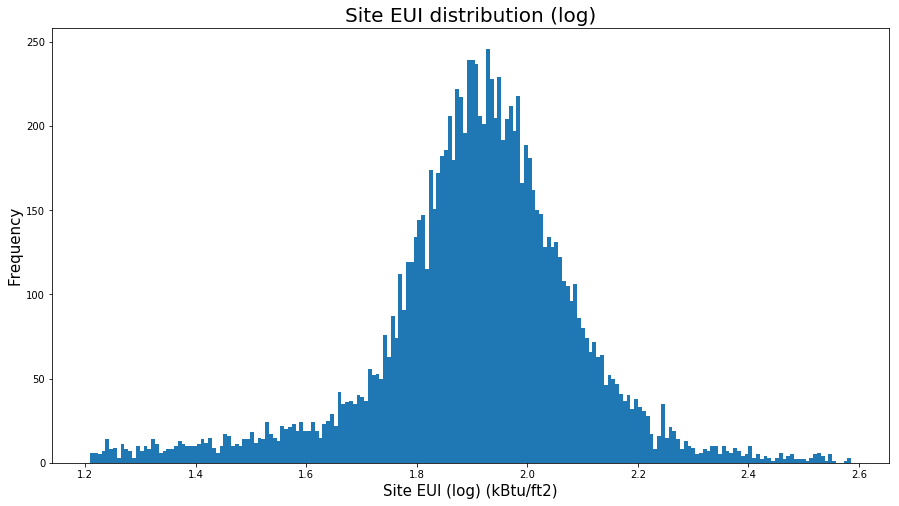

In [13]:
# plot again after cleaning
fig = figsize(15,8)
pl.hist(ll84['log_eui'][ll84['log_eui']<1000], bins=200)
pl.title('Site EUI distribution (log)', fontsize=20)
pl.xlabel('Site EUI (log) (kBtu/ft2)', fontsize=15)
pl.ylabel('Frequency', fontsize=15)
pl.show

### Fig.2 Site EUI log distribution
The log distribution looks more like a Gaussian distribution. 

In [14]:
ll84.eui.describe()

count    10995.000000
mean        88.492651
std         38.423844
min         16.200000
25%         67.000000
50%         83.100000
75%        103.000000
max        385.500000
Name: eui, dtype: float64

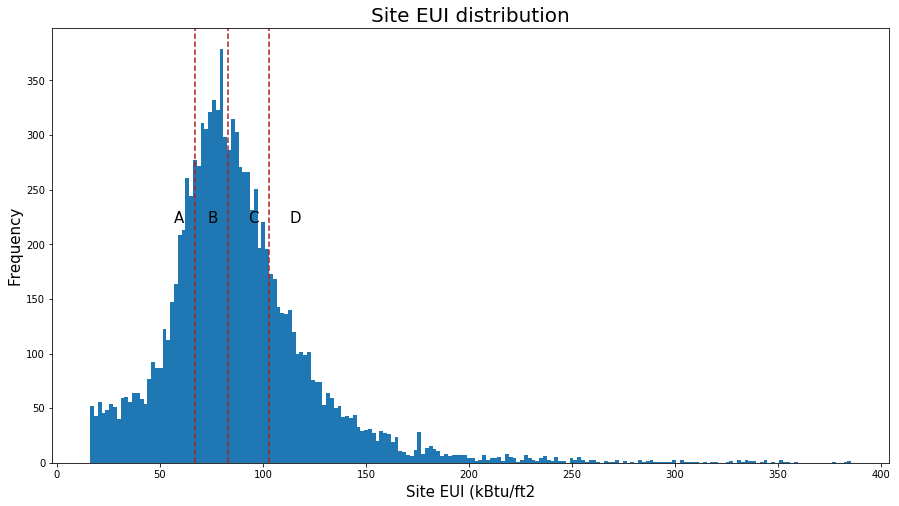

In [15]:
fig = figsize(15,8)
pl.hist(ll84['Site EUI (kBtu/ft_2)'], bins = 200)
for label, pos in zip(['A', 'B', 'C'], ll84['Site EUI (kBtu/ft_2)'].describe()[4:7].values):
    pl.axvline(x=pos, color='firebrick', linestyle='--')
    pl.text(pos-10,220, label, fontsize=15)
pl.text(pos+10,220, 'D', fontsize=15)
pl.title('Site EUI distribution', fontsize=20)
pl.xlabel('Site EUI (kBtu/ft2', fontsize=15)
pl.ylabel('Frequency', fontsize=15)

### Fig.3 Site EUI distribution, divided

## Understanding Relationships of variables in LL84 data

In [16]:
def makeCorrPlots(x, y):
    
    """Takes two variables as inputs, fits a univariate linear regression model,
    and outputs the scatter plot, linear fit and correlation coefficient"""
    
    # drop nans
    tmp = ll84[[x,y]]
    tmp = tmp.dropna()
    
    # fit univariate regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(tmp[x].astype(float64), tmp[y])
    
    # plot2
    plt.scatter(tmp[x].astype(float64), tmp[y], alpha=0.5)
    plt.plot(tmp[x].astype(float64),intercept + slope*tmp[x].astype(float64), color='firebrick')
    plt.title('%s v. %s (corr= %.2f)' %(y, x, np.corrcoef(tmp[x].astype(float64), tmp[y])[0][1]), fontsize=22)
    plt.xlabel("%s" %(x), fontsize=18)
    plt.ylabel("%s" %(y), fontsize=18)

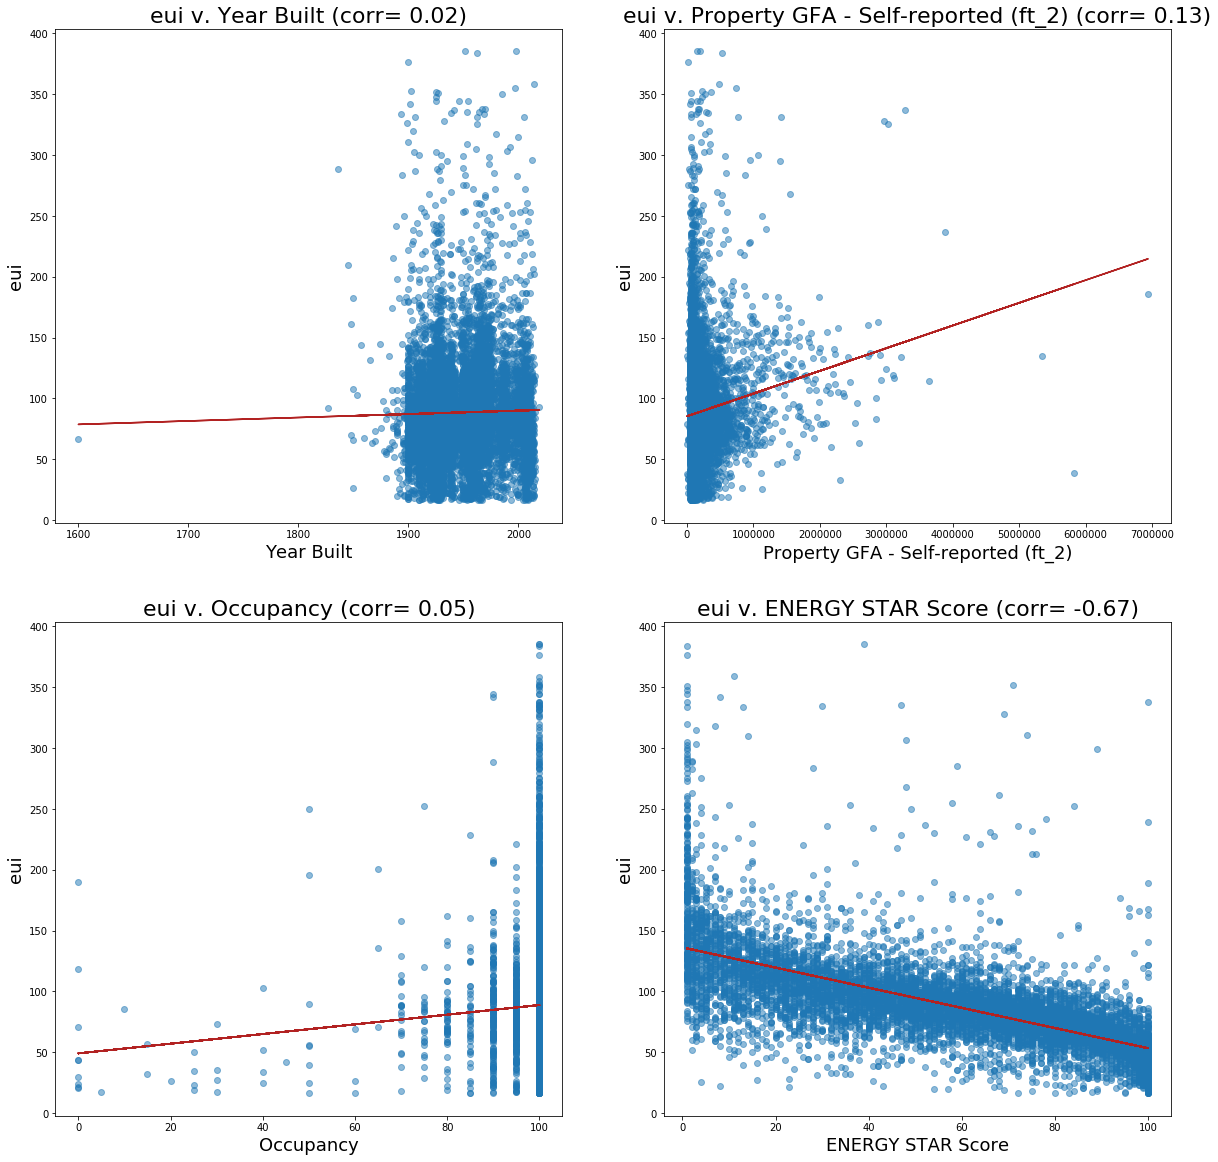

In [17]:
plt.figure(figsize=(20,20))
for i, var in enumerate(['Year Built', 'Property GFA - Self-reported (ft_2)', 'Occupancy', 'ENERGY STAR Score'],1):
    plt.subplot(2,2,i)
    makeCorrPlots(var, 'eui')

### Fig.4 Relationships between factors and Energy use intensity (EUI)
Possible relationships are shown between Property GFA (ft2) and Site ETU (kBtu/ft2);
A strong relationship is shown between ENERGY STAR Score and Site ETU (kBtu/ft2), as well as a strong predictive model. 

It seems hard to predict Site ETU (kBtu/ft2) relying on Year Built / Occupancy data.

In [18]:
ll84.columns

Index([u'Record Number', u'Order', u'NYC Borough, Block and Lot (BBL)',
       u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identification Numbers (BINs)',
       u'Property Name', u'Parent Property Id', u'Parent Property Name',
       u'Street Number', u'Street Name', u'Zip Code', u'Borough',
       u'DOF Benchmarking Submission Status',
       u'Primary Property Type - Self Selected',
       u'List of All Property Use Types at Property',
       u'Largest Property Use Type',
       u'Largest Property Use Type - Gross Floor Area (ft_2)',
       u'2nd Largest Property Use Type',
       u'2nd Largest Property Use - Gross Floor Area (ft_2)',
       u'3rd Largest Property Use Type',
       u'3rd Largest Property Use Type - Gross Floor Area (ft_2)',
       u'Year Built', u'Number of Buildings - Self-reported', u'Occupancy',
       u'Metered Areas (Energy)', u'Metered Areas  (Water)',
       u'ENERGY STAR Score', u'Site EUI (kBtu/ft_2)',
       u'Weather Nor

In [19]:
ll84 = ll84[['NYC Borough, Block and Lot (BBL)','Zip Code','Borough','Primary Property Type - Self Selected','Year Built','Property GFA - Self-reported (ft_2)','eui','log_eui']]
ll84.columns = ['BBL','ZipCode','Borough','PropertyType','YearBuilt','PropertyGFA(ft2)','eui','log_eui']
ll84.head()

,BBL,ZipCode,Borough,PropertyType,YearBuilt,PropertyGFA(ft2),eui,log_eui
0,1.003360e+09,10002.0,Manhattan,Multifamily Housing,1982,98000.0,73.7,1.867467
1,1.010618e+09,10019.0,Manhattan,Multifamily Housing,1950,57401.0,51.3,1.710117
2,1.014270e+09,10021.0,Manhattan,Multifamily Housing,1964,166433.0,44.9,1.652246
3,1.015180e+09,10128.0,Manhattan,Multifamily Housing,1960,114939.0,91.3,1.960471
5,1.000048e+09,10004.0,Manhattan,Office,1970,2428325.0,133.8,2.126456


In [20]:
ll84.dtypes

BBL                 float64
ZipCode             float64
Borough              object
PropertyType         object
YearBuilt            object
PropertyGFA(ft2)    float64
eui                 float64
log_eui             float64
dtype: object

In [21]:
ll84 = ll84.dropna(0)

In [22]:
ll84['YearBuilt'] = ll84['YearBuilt'].astype(int)
ll84['ZipCode'] = ll84['ZipCode'].astype(int)
ll84['BBL'] = ll84['BBL'].astype(int)
ll84.dtypes

BBL                   int64
ZipCode               int64
Borough              object
PropertyType         object
YearBuilt             int64
PropertyGFA(ft2)    float64
eui                 float64
log_eui             float64
dtype: object

In [23]:
len(ll84)

10778

In [24]:
# making a new df of median energy use by zipcode
zipcode = ll84.groupby('ZipCode').median()
zipcode = zipcode[['PropertyGFA(ft2)','eui','BBL']]

# Adding column of Energy Use - calculated by multiplying GFA*EUI
zipcode['EnergyUse'] = zipcode['PropertyGFA(ft2)']*zipcode['eui']
zipcode = zipcode.reset_index()
zipcode.head()

,ZipCode,PropertyGFA(ft2),eui,BBL,EnergyUse
0,10001,111112.5,73.7,1.008018e+09,8188991.25
1,10002,136070.0,92.0,1.003310e+09,12518440.00
2,10003,115428.0,84.2,1.005660e+09,9719037.60
3,10004,343345.0,93.8,1.000220e+09,32205761.00
4,10005,379572.0,85.1,1.000390e+09,32301577.20


# Energy Use and Asthma 

## Reading in Asthma hospital discharge data (2012-2014)
**Asthma data** were retrieved from https://www.health.ny.gov/statistics/ny_asthma/

Data of _5 NYC counties_ (divided to Zip Codes) were retrieved. Data were cleaned and merged in Excel, exported as csv file.

In [25]:
asthma = pd.read_csv('asthma.csv')
asthma = asthma[['ZipCode','Discharges2012-2014','DischargeRates']]
asthma.head()

,ZipCode,Discharges2012-2014,DischargeRates
0,10451,"1,125",77.1
1,10452,"1,312",56.1
2,10453,"1,222",50.5
3,10454,"1,075",94.8
4,10455,"1,052",84.5


In [26]:
asthma.dtypes

ZipCode                  int64
Discharges2012-2014     object
DischargeRates         float64
dtype: object

In [27]:
EUasthma = asthma.merge(zipcode, on='ZipCode')
EUasthma.head()

,ZipCode,Discharges2012-2014,DischargeRates,PropertyGFA(ft2),eui,BBL,EnergyUse
0,10451,"1,125",77.1,109841.5,89.25,2.024425e+09,9803353.875
1,10452,"1,312",56.1,72323.0,95.35,2.025170e+09,6895998.050
2,10453,"1,222",50.5,69416.0,95.10,2.028770e+09,6601461.600
3,10454,"1,075",94.8,99277.0,65.00,2.025530e+09,6453005.000
4,10455,"1,052",84.5,76743.0,78.00,2.026000e+09,5985954.000


In [28]:
len(EUasthma)

167

## Descriptive Statistics

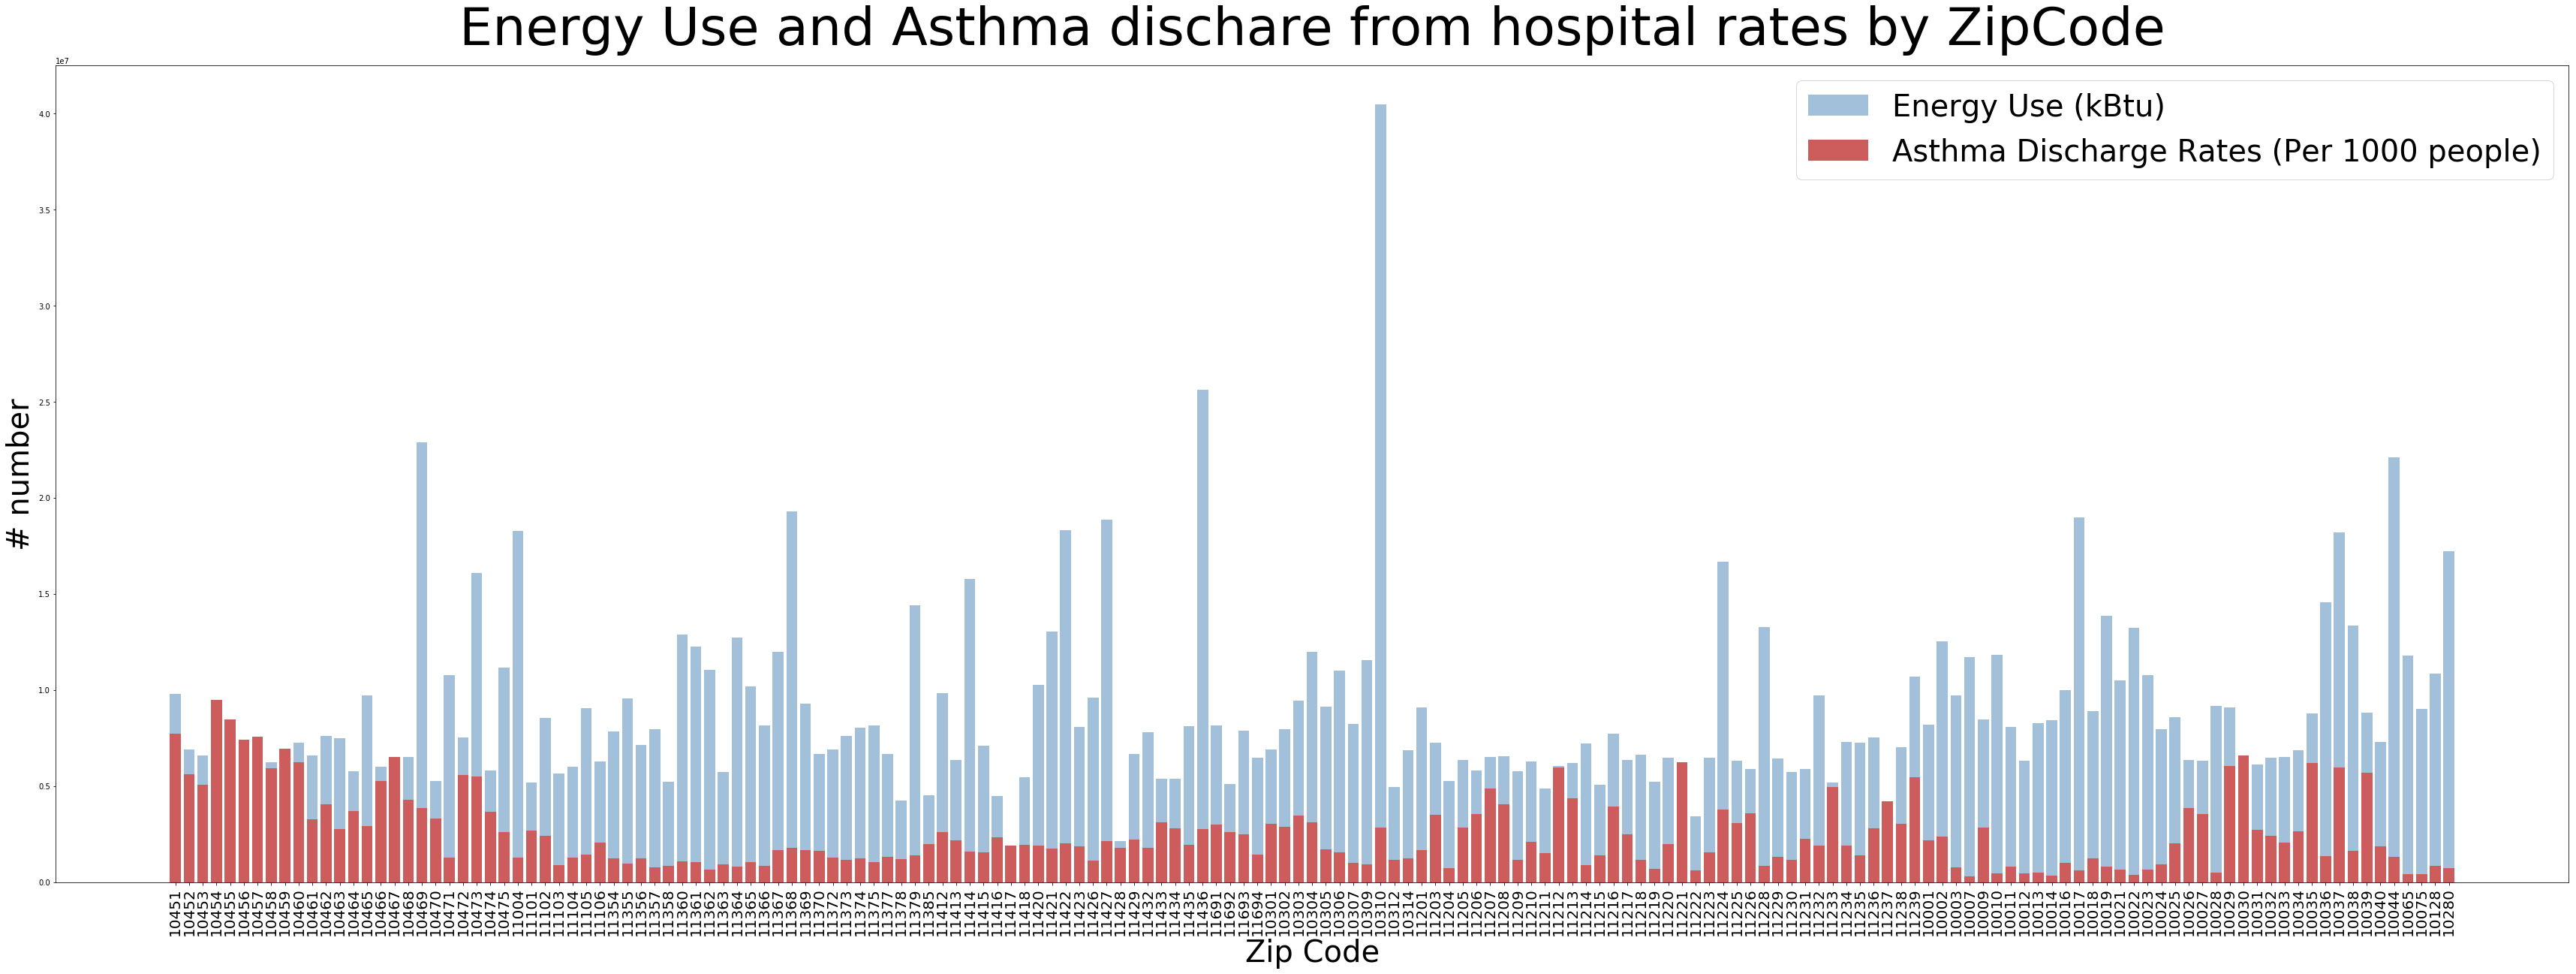

In [29]:
pl.figure(figsize = (60,20))

ax = pl.bar(range(len(EUasthma)), EUasthma['EnergyUse'], align='center', color="SteelBlue", alpha=0.5, label='Energy Use (kBtu)')
ax0 = pl.bar(range(len(EUasthma)), EUasthma["DischargeRates"]*100000, align='center', color="IndianRed", label='Asthma Discharge Rates (Per 1000 people)')
pl.xticks(range(len(EUasthma)), EUasthma["ZipCode"], fontsize = 20, rotation=90)

pl.xlabel('Zip Code', fontsize=40)
pl.ylabel('# number', fontsize=40)
pl.title('Energy Use and Asthma dischare from hospital rates by ZipCode', fontsize=70, y=1.02)
pl.legend(prop={'size': 40})
#sns.set_style("whitegrid")

### Fig.5 Energy Use and Asthma discharge from hospital rates by ZipCode

revealing the above Energy use (_blue_) and Asthma discharge rates (_red_) information, layered one on the other, it is hard to understand the nature of the relationship between the two and whether any correlation exists between them. 

## Building a linear regression model

In [30]:
EUasthma_model = smf.ols('DischargeRates ~ EnergyUse', data=EUasthma).fit()

In [31]:
EUasthma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         DischargeRates   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.335
Date:                Tue, 14 Nov 2017   Prob (F-statistic):              0.128
Time:                        02:58:43   Log-Likelihood:                -724.97
No. Observations:                 167   AIC:                             1454.
Df Residuals:                     165   BIC:                             1460.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     29.3191      3.140      9.337      0.000        23.119    35.519
EnergyUse  -4.792e-07   3.14e-07     -1.528      0.128      -1.1e-06   1.4e-07
==============================================================================
Omnibus:                       39.069   Durbin-Watson:                   0.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.072
Skew:                           1.310   Prob(JB):                     2.45e-13
Kurtosis:                       4.217   Cond. No.                     2.17e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
print('R-squared of model#1 (Energy Use and Asthma discharge rates) is: %.3f'%EUasthma_model.rsquared)

R-squared of model#1 (Energy Use and Asthma discharge rates) is: 0.014


In [33]:
EUasthma_model.params

Intercept    2.931908e+01
EnergyUse   -4.791500e-07
dtype: float64

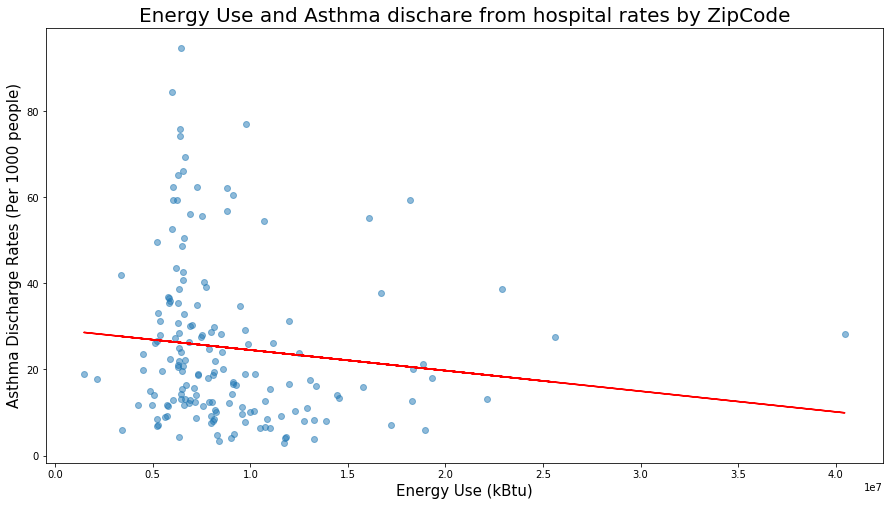

In [34]:
fig = pl.figure(figsize(15,8))
ax = fig.add_subplot(111)
ax.plot(EUasthma.EnergyUse, EUasthma.DischargeRates, 'o', alpha=0.5)
ax.plot(EUasthma.EnergyUse, EUasthma_model.predict(), 'r-')
ax.set_title('Energy Use and Asthma dischare from hospital rates by ZipCode', fontsize=20)
ax.set_xlabel('Energy Use (kBtu)',fontsize=15)
ax.set_ylabel('Asthma Discharge Rates (Per 1000 people)',fontsize=15);

### Fig.6 Scatter plot + Predictive Model of Energy Use and Asthma discharge from hospital rates
** by ZipCode

The model reveals a weak negative correlation (R-squared = 0.014; slope of the model = -4.791500e-07). Thus it is hard to predict Asthma rates according to Energy Use. It is possible that the relationship is not linear or that other factors taken into consideration together alongside with EU will give a better model.

____

# Energy Performance and Income

## LL84 data: extracting only multifamily housing property type


In [35]:
ll84_res = ll84[ll84['PropertyType'] == 'Multifamily Housing']
ll84_res = ll84_res[['BBL', 'eui']]
ll84_res.head()

,BBL,eui
0,1003360005,73.7
1,1010617501,51.3
2,1014270028,44.9
3,1015180024,91.3
8,1000087501,137.2


In [36]:
ll84_res.dtypes

BBL      int64
eui    float64
dtype: object

In [37]:
len(ll84_res)

8224

## Reading in Income data (ACS 2015)
**CENSUS data** were retrieved from http://www1.nyc.gov/site/planning/data-maps/nyc-population.page. The data were cleaned from unnecessary and/or private information before import.

In [38]:
income = pd.read_csv('census.csv')
income.columns = ['CD','MedianHouseholdIncome($)']
income.head()

,CD,MedianHouseholdIncome($)
0,208.0,58202.0
1,212.0,45728.0
2,210.0,54908.0
3,211.0,46305.0
4,203.0,22632.0


In [39]:
income = income.dropna(0)
income['CD'] = income['CD'].astype(int)
income.dtypes

CD                            int64
MedianHouseholdIncome($)    float64
dtype: object

In [40]:
len(income)

59

## Reading in PLUTO data to convert BBL to Community District (CD)

**PLUTO data** were retrieved from https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page

In [41]:
PUIDATA = os.getenv('PUIDATA')
print(PUIDATA)

/home/cusp/dcr346/PUIdata


In [42]:
BK = pd.read_csv(PUIDATA + '/BK.csv')
BX = pd.read_csv(PUIDATA + '/BX.csv')
MN = pd.read_csv(PUIDATA + '/MN.csv')
QN = pd.read_csv(PUIDATA + '/QN.csv')
SI = pd.read_csv(PUIDATA + '/SI.csv')

pluto = pd.concat([BK, BX, MN, QN, SI], axis=0)
pluto.head()

,CD,BBL
0,302,3000010001
1,302,3000010050
2,302,3000017501
3,302,3000030001
4,302,3000030005


In [43]:
len(pluto)

858370

In [44]:
pluto.dtypes

CD     int64
BBL    int64
dtype: object

## Merging the three datasets

In [45]:
# Merging PLUTO data with Energy data on BBL

EnergyInc = pluto.merge(ll84_res, on='BBL')
EnergyInc.head()

,CD,BBL,eui
0,302,3000280005,31.8
1,302,3000287502,34.3
2,302,3000317503,64.0
3,302,3000327501,36.6
4,302,3000360016,99.4


In [46]:
len(EnergyInc)

8220

In [47]:
# groupby CD 

EnergyInc_CD = EnergyInc.groupby('CD').mean().reset_index()
EnergyInc_CD.head()

,CD,BBL,eui
0,101,1001113565,82.716779
1,102,1005528315,82.525381
2,103,1003836908,87.458889
3,104,1008745791,84.686667
4,105,1009452578,87.483099


In [48]:
len(EnergyInc_CD)

60

In [49]:
# Merging Income data with EnergyInc data on CD

EnergyInc_CD = EnergyInc_CD.merge(income, on='CD')

In [50]:
EnergyInc_CD.columns = ['CD','BBL','eui','MedianHouseholdIncome']
EnergyInc_CD.head()

,CD,BBL,eui,MedianHouseholdIncome
0,101,1001113565,82.716779,120408.0
1,102,1005528315,82.525381,120408.0
2,103,1003836908,87.458889,42102.0
3,104,1008745791,84.686667,97121.0
4,105,1009452578,87.483099,97121.0


In [51]:
len(EnergyInc_CD)

59

## Descriptive Statistics

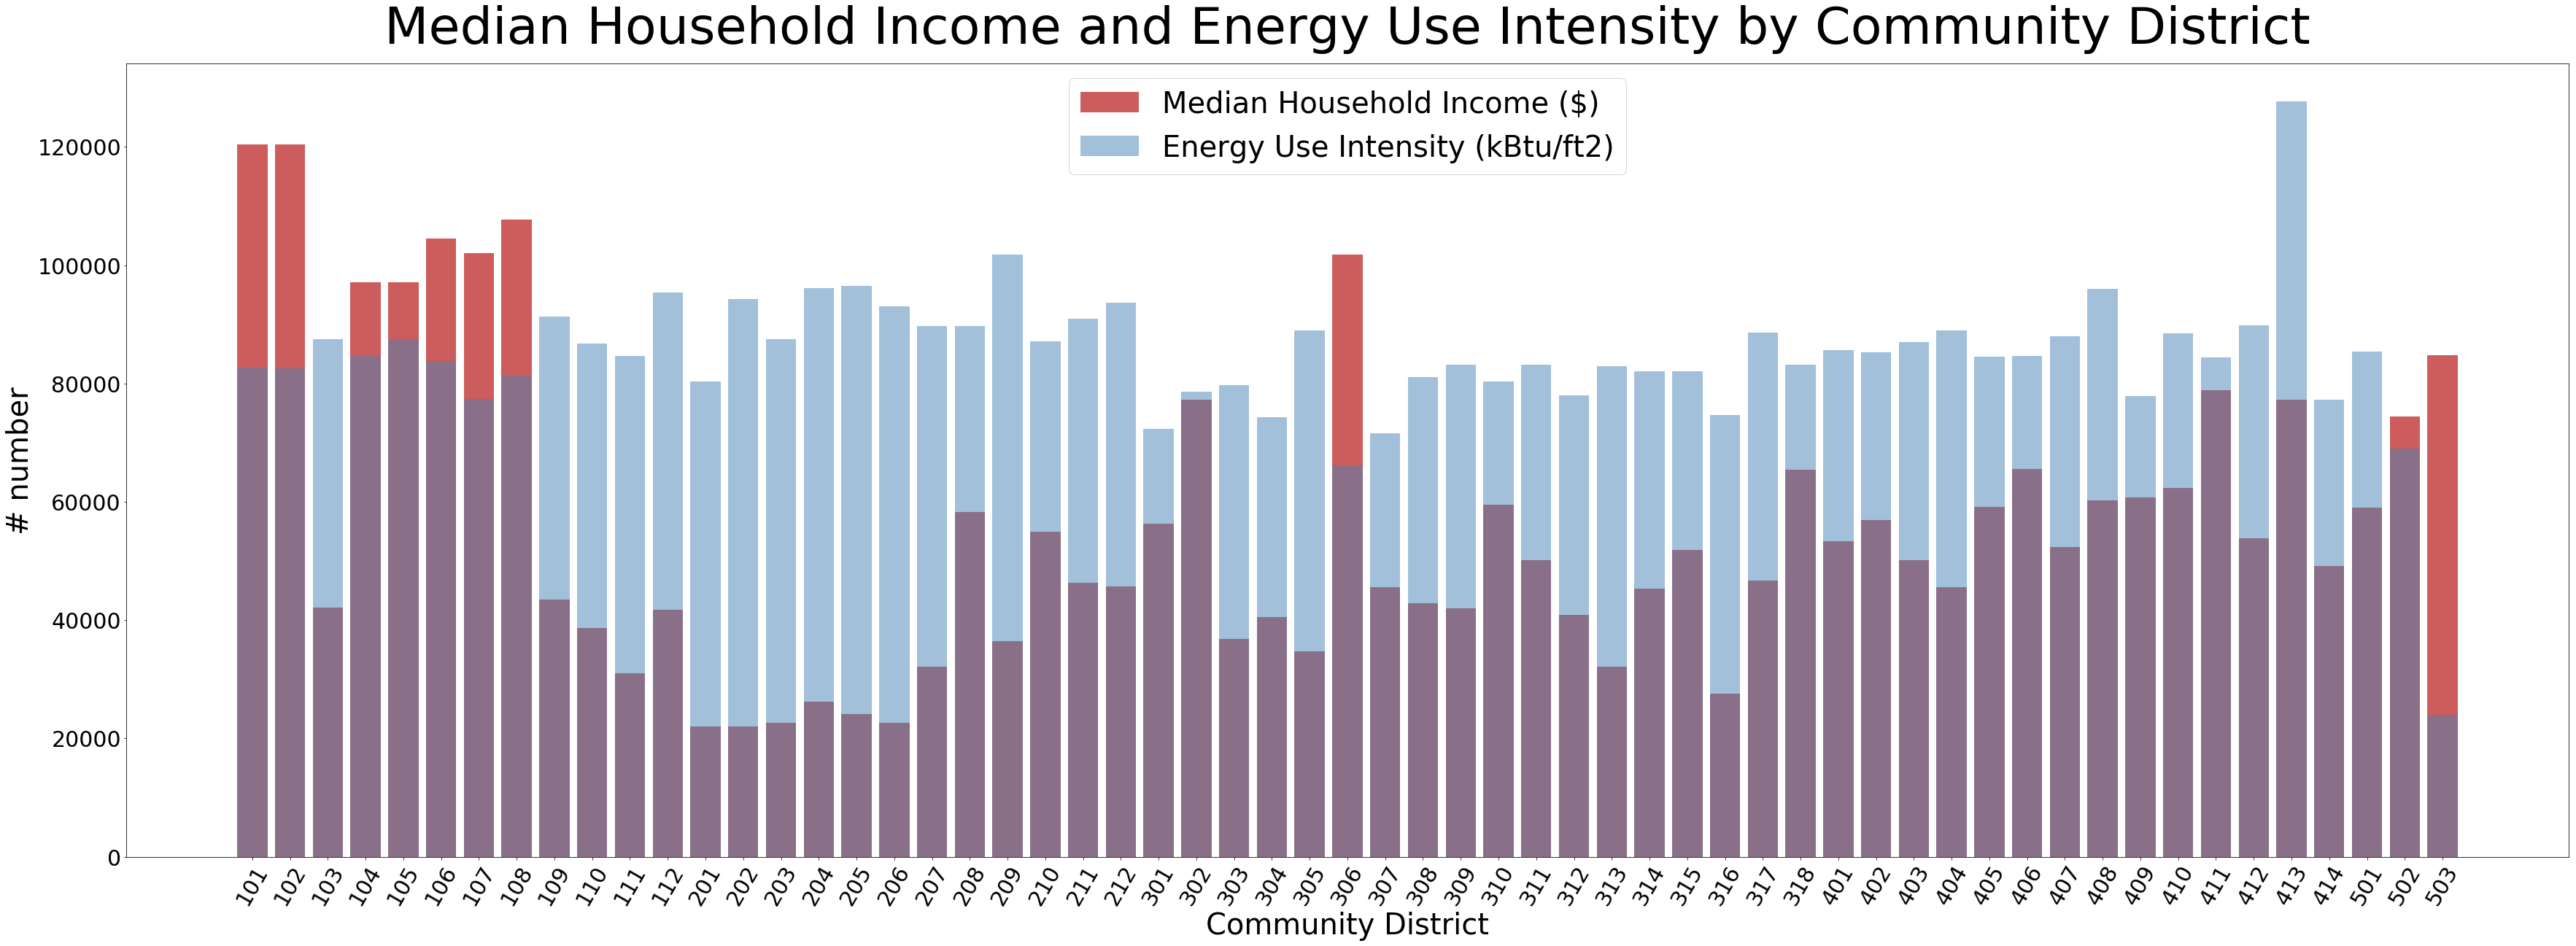

In [52]:
pl.figure(figsize = (60,20))

ax = pl.bar(range(len(EnergyInc_CD)), EnergyInc_CD['MedianHouseholdIncome'], align='center', color="IndianRed", label='Median Household Income ($)')
ax0 = pl.bar(range(len(EnergyInc_CD)), EnergyInc_CD["eui"]*1000, align='center', color="SteelBlue", alpha=0.5, label='Energy Use Intensity (kBtu/ft2)')
pl.xticks(range(len(EnergyInc_CD)), EnergyInc_CD["CD"], fontsize = 30, rotation=60)
pl.yticks(fontsize = 30)

pl.xlabel('Community District', fontsize=40)
pl.ylabel('# number', fontsize=40)
pl.title('Median Household Income and Energy Use Intensity by Community District', fontsize=70, y=1.02)
pl.legend(prop={'size': 40})

### Fig.7 Median Household Income and Energy Use Intensity by Community District

revealing the above Energy use (_blue_) and Median Household Income (_red_) information, layered one over the other, it is hard to understand the nature of the relationship between the two and whether any correlation exists between them. 

## Building a model to predict Energy Consumption using Median Income Houshold

In [53]:
EnergyInc_model = smf.ols('eui ~ MedianHouseholdIncome', data=EnergyInc_CD).fit()

In [54]:
EnergyInc_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    eui   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     3.516
Date:                Tue, 14 Nov 2017   Prob (F-statistic):             0.0659
Time:                        02:58:50   Log-Likelihood:                -227.98
No. Observations:                  59   AIC:                             460.0
Df Residuals:                      57   BIC:                             464.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                90.8623      3.759     24.170      0.000        83.334    98.390
MedianHouseholdIncome    -0.0001   6.14e-05     -1.875      0.066        -0.000  7.83e-06
==============================================================================
Omnibus:                       35.039   Durbin-Watson:                   1.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              344.563
Skew:                          -1.061   Prob(JB):                     1.51e-75
Kurtosis:                      14.647   Cond. No.                     1.51e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
print('R-squared of model#2 (Median Household Income and Energy Use Intensity) is: %.3f'%EnergyInc_model.rsquared)

R-squared of model#2 (Median Household Income and Energy Use Intensity) is: 0.058


In [56]:
EnergyInc_model.params

Intercept                90.862297
MedianHouseholdIncome    -0.000115
dtype: float64

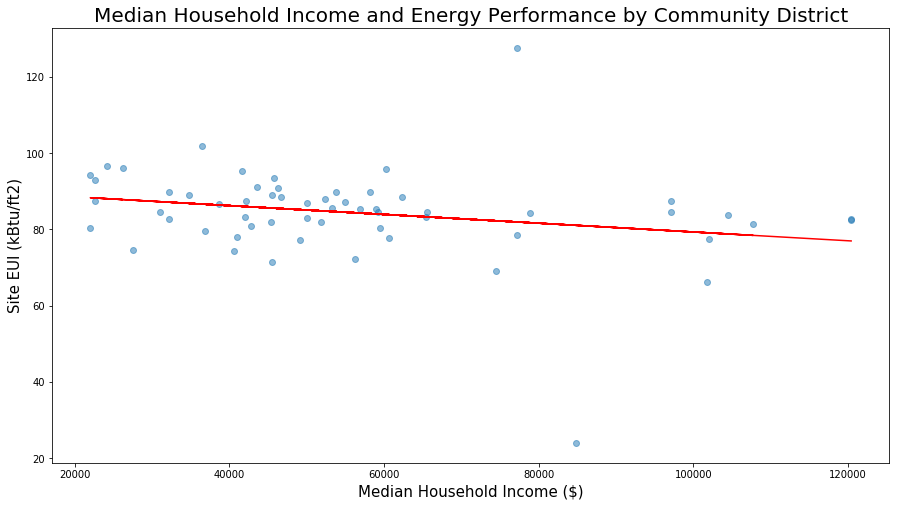

In [57]:
fig = pl.figure(figsize(15,8))
ax = fig.add_subplot(111)
ax.plot(EnergyInc_CD.MedianHouseholdIncome, EnergyInc_CD.eui, 'o', alpha=0.5)
ax.plot(EnergyInc_CD.MedianHouseholdIncome, EnergyInc_model.predict(), 'r-')
ax.set_title('Median Household Income and Energy Performance by Community District', fontsize=20)
ax.set_xlabel('Median Household Income ($)',fontsize=15)
ax.set_ylabel('Site EUI (kBtu/ft2)',fontsize=15);

### Fig.8 Scatter plot + Predictive Model of Median Household Income and Energy Use Intensity
**by Community District

The model reveals a weak negative correlation (R-squared = 0.058; slope of the model = -0.000115). Thus it is hard to predict Energy Use Intensity of a building according to the median household income. It is possible that the relationship is not linear or that other factors taken into consideration together alongside with income will give a better model.

___

# Results

The above two model were insufficient and revealed weak correlations between the variables analyzed. 

A possible reason to the lack of success of the models is that when looking on Zip Codes as well as on Community Districts, we practically assume that people spend most of their time where they live, which is obviously a wrong assumption. 

One way to deal with that limitation and to isolate the place a person lives as the main factor when predicting asthma is to limit the population to children only. Children are most likely to spend most of their days and nights in/close to their homes. 

The Asthma dataset is divided to ages group, what makes the suggested task possible. 


In [59]:
asthma_child = pd.read_csv('asthma017.csv')
asthma_child.head()

,ZipCode,Discharges2012-2014,DischargeRates
0,11201,98,35.9
1,11203,356,70.0
2,11204,36,5.6
3,11205,132,39.0
4,11206,304,40.2


In [60]:
asthma_child.dtypes

ZipCode                  int64
Discharges2012-2014      int64
DischargeRates         float64
dtype: object

In [61]:
EUasthma_ch = asthma_child.merge(zipcode, on='ZipCode')
EUasthma_ch.head()

,ZipCode,Discharges2012-2014,DischargeRates,PropertyGFA(ft2),eui,BBL,EnergyUse
0,11201,98,35.9,121818.5,74.8,3.002315e+09,9112023.8
1,11203,356,70.0,79541.0,91.4,3.048130e+09,7270047.4
2,11204,36,5.6,72000.0,73.0,3.065530e+09,5256000.0
3,11205,132,39.0,86905.0,73.0,3.019170e+09,6344065.0
4,11206,304,40.2,84000.0,69.2,3.030780e+09,5812800.0


In [62]:
len(EUasthma_ch)

172

In [63]:
EUasthmaChild_model = smf.ols('DischargeRates ~ EnergyUse', data=EUasthma_ch).fit()

In [64]:
EUasthmaChild_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         DischargeRates   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     5.693
Date:                Tue, 14 Nov 2017   Prob (F-statistic):             0.0181
Time:                        02:59:52   Log-Likelihood:                -819.30
No. Observations:                 172   AIC:                             1643.
Df Residuals:                     170   BIC:                             1649.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     44.7123      4.308     10.379      0.000        36.208    53.217
EnergyUse  -9.538e-07      4e-07     -2.386      0.018     -1.74e-06 -1.65e-07
==============================================================================
Omnibus:                       28.608   Durbin-Watson:                   0.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.979
Skew:                           1.089   Prob(JB):                     9.33e-09
Kurtosis:                       3.644   Cond. No.                     2.14e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
EUasthmaChild_model.params

Intercept    4.471231e+01
EnergyUse   -9.537701e-07
dtype: float64

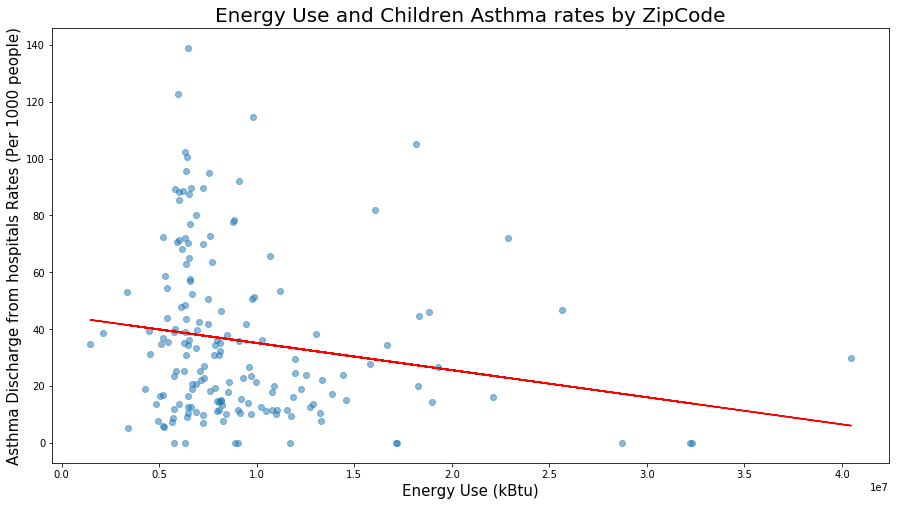

In [66]:
fig = pl.figure(figsize(15,8))
ax = fig.add_subplot(111)
ax.plot(EUasthma_ch.EnergyUse, EUasthma_ch.DischargeRates, 'o', alpha=0.5)
ax.plot(EUasthma_ch.EnergyUse, EUasthmaChild_model.predict(), 'r-')
ax.set_title('Energy Use and Children Asthma rates by ZipCode', fontsize=20)
ax.set_xlabel('Energy Use (kBtu)',fontsize=15)
ax.set_ylabel('Asthma Discharge from hospitals Rates (Per 1000 people)',fontsize=15);

### Fig.9 Scatter plot + Predictive Model of Energy Use and Children Asthma rates
**by ZipCode

The model reveals a weak negative correlation (R-squared = 0.032; slope of the model = -9.537701e-07). Thus it is hard to predict Children Asthma rates according to Energy Use. This data and model are very similar to those in Fig.6 (Total population and not children only). The reason might be the high percentage of children (age 0-17) asthma from total population. Still, this model seems to be a better model for explaining and predicting Asthma rates as a dependent variable of Energy Use. Taking into consideration other factors together alongside with EU, for example median household income, might give us a better model. 

# Multilinear regression 

In [67]:
EUasthma_ch_mul = pd.read_csv('asthma017.csv')
EUasthma_ch_mul.head()

,ZipCode,Discharges2012-2014,DischargeRates
0,11201,98,35.9
1,11203,356,70.0
2,11204,36,5.6
3,11205,132,39.0
4,11206,304,40.2


In [68]:
zipcode_res = ll84[ll84['PropertyType'] == 'Multifamily Housing']
zipcode_res = zipcode_res.groupby('ZipCode').median()
zipcode_res = zipcode_res[['PropertyGFA(ft2)','eui','BBL']]

# Adding column of Energy Use - calculated by multiplying GFA*EUI
zipcode_res['EnergyUse'] = zipcode_res['PropertyGFA(ft2)']*zipcode_res['eui']
zipcode_res = zipcode_res.reset_index()
zipcode_res.head()

,ZipCode,PropertyGFA(ft2),eui,BBL,EnergyUse
0,10001,115925.0,73.30,1.007790e+09,8.497302e+06
1,10002,138791.5,92.00,1.003180e+09,1.276882e+07
2,10003,115087.5,81.95,1.005640e+09,9.431421e+06
3,10004,233292.0,103.40,1.000249e+09,2.412239e+07
4,10005,337000.0,84.60,1.000288e+09,2.851020e+07


In [69]:
EUasthma_ch_mul = EUasthma_ch_mul.merge(zipcode_res, on='ZipCode')
EUasthma_ch_mul.head()

,ZipCode,Discharges2012-2014,DischargeRates,PropertyGFA(ft2),eui,BBL,EnergyUse
0,11201,98,35.9,120400.0,74.7,3.002368e+09,8993880.0
1,11203,356,70.0,79541.0,90.0,3.048150e+09,7158690.0
2,11204,36,5.6,66240.0,74.2,3.065680e+09,4915008.0
3,11205,132,39.0,94309.0,80.2,3.019210e+09,7563581.8
4,11206,304,40.2,78162.0,82.2,3.030600e+09,6424916.4


In [70]:
EUasthma_ch_mul = EUasthma_ch_mul.merge(pluto, on='BBL')
EUasthma_ch_mul = EUasthma_ch_mul.merge(income, on='CD')
EUasthma_ch_mul = EUasthma_ch_mul[['ZipCode','DischargeRates','eui','BBL','EnergyUse','MedianHouseholdIncome($)']]
EUasthma_ch_mul.head()

,ZipCode,DischargeRates,eui,BBL,EnergyUse,MedianHouseholdIncome($)
0,11201,35.9,74.7,3.002368e+09,8993880.0,77220.0
1,11203,70.0,90.0,3.048150e+09,7158690.0,41984.0
2,11213,68.3,79.1,3.014030e+09,6204445.8,41984.0
3,11204,5.6,74.2,3.065680e+09,4915008.0,40934.0
4,11232,23.6,87.9,3.009230e+09,6299705.1,40934.0


In [71]:
EUasthma_ch_mul.columns = ['ZipCode','DischargeRates','eui','BBL','EnergyUse','MedianHouseholdIncome']

In [72]:
EUasthma_multi = smf.ols(formula= 'DischargeRates ~ EnergyUse + MedianHouseholdIncome',data=EUasthma_ch_mul).fit()
print(EUasthma_multi.summary())

                            OLS Regression Results                            
Dep. Variable:         DischargeRates   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     30.38
Date:                Tue, 14 Nov 2017   Prob (F-statistic):           9.27e-11
Time:                        02:59:55   Log-Likelihood:                -418.70
No. Observations:                  91   AIC:                             843.4
Df Residuals:                      88   BIC:                             850.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                83.60

## Results of Multilinear regression
The multilinear model gave, allegedly, a much better R-squared: 0.408, but still very small numbers of coefficients to its independent variables: 3.274e-07 For Energy Use and -0.0008 For income. These results may imply a multicollinearity, which makes this model unreliable. Although we saw in Model 2 that a correlation between Income and Site EUI (kBtu/ft2) barely exists, it was wrong to infer the relationship between Income and total Energy Use (kBtu) is also negligible.


## Discussion and Conclution

All the models were executed in this analysis didn’t sufficiently predict or explain the observed data, whether they had very small R-squared values or had multicollinearity issues. As discussed in the previews section, these poor results do not necessarily infer the lack of relationship between Energy Use and Asthma rates as well as between Income and Site EUI. They do mean that the models are too simple and / or that the geographical references we picked, zip codes and community districts, are too broad or misleading, due to the argue by which people do not necessarily primarily expose to the air in the building they live in or its immediate surrounding. To this objective, including only children aged 0-17 in the analysis strengthen the model but only marginally, and turned to give us not a much better explanation of the asthma rates data. It is possible that calculating only young children, aged 0-4 for example, would have given a deeper understanding, a more reliable model and would revealed a stronger correlation. Unfortunately, these data was available only in the County level, which would be too broad for inferring any reasonable conclusion.


___

In [73]:
# export to csv -- in order to import to arcGIS to create maps

EnergyInc_CD.to_csv('EnergyInc_CD', encoding='utf-8', index=False)
EUasthma.to_csv('EUasthma', encoding='utf-8', index=False)
EUasthma_ch.to_csv('EUasthma_ch', encoding='utf-8', index=False)